In [20]:
# %cd /content/drive/My Drive/ColabNotebooks/mnist
# %ls

In [21]:
from __future__ import print_function
from __future__ import division
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
import copy
import sys
print("PyTorch Version: ",torch.__version__)
print("Torchvision Version: ",torchvision.__version__)

PyTorch Version:  1.11.0
Torchvision Version:  0.12.0


In [22]:
def makedir(dir):
  if not os.path.exists(dir):
    os.makedirs(dir)

In [23]:
# Top level data directory. Here we assume the format of the directory conforms
#   to the ImageFolder structure
data_dir = "D:\\HDD_Study\\HDD_Github\\Gesture_Game_lerning"
# data_dir = "C:\ex\sen\data\max_square\\train_val"
# Models to choose from [resnet, alexnet, vgg, squeezenet, densenet, inception]
model_name = "resnet"
#結果出力ディレクトリ
output_name = "model"
# Number of classes in the dataset
num_classes = 3
# Batch size for training (change depending on how much memory you have)
batch_size = 128
# Number of epochs to train for
num_epochs = 10
# Flag for feature extracting. When False, we finetune the whole model,
#   when True we only update the reshaped layer params
feature_extract = False

# last or best
last = False

output_base_dir = "C:\\Users\\H3rb\\source\\GitHub\\HandGesture_Game"
out_dir = os.path.join(output_base_dir,output_name)
# if os.path.exists(out_dir):
#   print("出力ディレクトリ名が被っているよ")
#   sys.exit()

makedir(out_dir)

In [24]:
def train_model(model, dataloaders, criterion, optimizer, last, num_epochs=25, is_inception=False):
    since = time.time()

    train_acc_history = []
    val_acc_history = []

    best_model_wts = copy.deepcopy(model.state_dict())
    last_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    # Get model outputs and calculate loss
                    # Special case for inception because in training it has an auxiliary output. In train
                    #   mode we calculate the loss by summing the final output and the auxiliary output
                    #   but in testing we only consider the final output.
                    if is_inception and phase == 'train':
                        # From https://discuss.pytorch.org/t/how-to-optimize-inception-model-with-auxiliary-classifiers/7958
                        outputs, aux_outputs = model(inputs)
                        loss1 = criterion(outputs, labels)
                        loss2 = criterion(aux_outputs, labels)
                        loss = loss1 + 0.4*loss2
                    else:
                        outputs = model(inputs)
                        loss = criterion(outputs, labels)

                    _, preds = torch.max(outputs, 1)

                    ###########
                    # 追加
                    ###########
                    # print("preds")
                    # print(preds)
                    # print("label")
                    # print(labels)


                    ###########

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
                

            epoch_loss = running_loss / len(dataloaders[phase].dataset)
            epoch_acc = running_corrects.double() / len(dataloaders[phase].dataset)

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(phase, epoch_loss, epoch_acc))

            #######
            # 追加
            #######
            # if phase == 'val':
            #     print('{} / {} = Acc: {:.4f}'.format(running_corrects.double(), len(dataloaders[phase].dataset), epoch_acc))

            #     print(preds)

            #     print(labels.data)

            if phase == 'train':
                train_acc_history.append(epoch_acc)
            #######

            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())
            if phase == 'val':
                val_acc_history.append(epoch_acc)
            
            last_model_wts = copy.deepcopy(model.state_dict())

        print()

    last_model_wts = copy.deepcopy(model.state_dict())
    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    # load best model weights
    if last:
        model.load_state_dict(last_model_wts)
    else:
        model.load_state_dict(best_model_wts)

    return model, train_acc_history, val_acc_history

In [25]:
def set_parameter_requires_grad(model, feature_extracting):
    if feature_extracting:
        for param in model.parameters():
            param.requires_grad = False

In [26]:
from HandGesture_module_v2 import ai as gestureai

# Initialize the model for this run
model_ft, input_size = gestureai.initialize_model(model_name, num_classes, feature_extract, use_pretrained=True,binary=True)

In [27]:
# Data augmentation and normalization for training
# Just normalization for validation
# data_transforms = {
#     'train': transforms.Compose([
#         transforms.RandomResizedCrop(input_size),
#         # transforms.RandomHorizontalFlip(),
#         transforms.ToTensor(),
#         transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
#     ]),
#     'val': transforms.Compose([
#         transforms.Resize(input_size),
#         transforms.CenterCrop(input_size),
#         transforms.ToTensor(),
#         transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
#     ]),
# }
#手袋
data_transforms = {
    'train': transforms.Compose([
        transforms.Resize(input_size),
        transforms.ToTensor(),
    ]),
    'val': transforms.Compose([
        transforms.Resize(input_size),
        transforms.ToTensor(),
    ]),
}
# data_transforms = {
#     'train': transforms.Compose([
#         transforms.Resize(input_size),
#         transforms.RandomHorizontalFlip(),

#         #データ拡張実験
#         transforms.RandomVerticalFlip(),
#         transforms.RandomRotation(degrees=(0,360),expand=True),
#         transforms.Resize(input_size),

#         transforms.ToTensor(),
#         transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
#     ]),
#     'val': transforms.Compose([
#         transforms.Resize(input_size),
#         transforms.CenterCrop(input_size),
#         transforms.ToTensor(),
#         transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
#     ]),
# }

print("Initializing Datasets and Dataloaders...")

# Create training and validation datasets
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x), data_transforms[x]) for x in ['train', 'val']}
# Create training and validation dataloaders
dataloaders_dict = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=batch_size, shuffle=True, num_workers=4) for x in ['train', 'val']}
class_names = image_datasets['train'].classes
# Detect if we have a GPU available
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

Initializing Datasets and Dataloaders...


In [28]:
# from google.colab import drive
# drive.mount('/content/drive')

In [29]:
model_ft = model_ft.to(device)

# Gather the parameters to be optimized/updated in this run. If we are
#  finetuning we will be updating all parameters. However, if we are
#  doing feature extract method, we will only update the parameters
#  that we have just initialized, i.e. the parameters with requires_grad
#  is True.
params_to_update = model_ft.parameters()
print("Params to learn:")
if feature_extract:
    params_to_update = []
    for name,param in model_ft.named_parameters():
        if param.requires_grad == True:
            params_to_update.append(param)
            print("\t",name)
else:
    for name,param in model_ft.named_parameters():
        if param.requires_grad == True:
            print("\t",name)

# Observe that all parameters are being optimized
optimizer_ft = optim.SGD(params_to_update, lr=0.001, momentum=0.9)

Params to learn:
	 conv1.weight
	 bn1.weight
	 bn1.bias
	 layer1.0.conv1.weight
	 layer1.0.bn1.weight
	 layer1.0.bn1.bias
	 layer1.0.conv2.weight
	 layer1.0.bn2.weight
	 layer1.0.bn2.bias
	 layer1.1.conv1.weight
	 layer1.1.bn1.weight
	 layer1.1.bn1.bias
	 layer1.1.conv2.weight
	 layer1.1.bn2.weight
	 layer1.1.bn2.bias
	 layer2.0.conv1.weight
	 layer2.0.bn1.weight
	 layer2.0.bn1.bias
	 layer2.0.conv2.weight
	 layer2.0.bn2.weight
	 layer2.0.bn2.bias
	 layer2.0.downsample.0.weight
	 layer2.0.downsample.1.weight
	 layer2.0.downsample.1.bias
	 layer2.1.conv1.weight
	 layer2.1.bn1.weight
	 layer2.1.bn1.bias
	 layer2.1.conv2.weight
	 layer2.1.bn2.weight
	 layer2.1.bn2.bias
	 layer3.0.conv1.weight
	 layer3.0.bn1.weight
	 layer3.0.bn1.bias
	 layer3.0.conv2.weight
	 layer3.0.bn2.weight
	 layer3.0.bn2.bias
	 layer3.0.downsample.0.weight
	 layer3.0.downsample.1.weight
	 layer3.0.downsample.1.bias
	 layer3.1.conv1.weight
	 layer3.1.bn1.weight
	 layer3.1.bn1.bias
	 layer3.1.conv2.weight
	 layer3.1.b

In [30]:
# Setup the loss fxn
criterion = nn.CrossEntropyLoss()

# Train and evaluate
model_ft, train_acc_hist_tensor, val_acc_hist_tensor = train_model(model_ft, dataloaders_dict, criterion, optimizer_ft, last, num_epochs=num_epochs, is_inception=(model_name=="inception"))

Epoch 0/9
----------


RuntimeError: Given groups=1, weight of size [64, 1, 7, 7], expected input[128, 3, 224, 224] to have 1 channels, but got 3 channels instead

In [ ]:
from PIL import Image

def tensor_to_np(inp):
    "imshow for Tesor"
    inp = inp.numpy().transpose((1,2,0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    return inp

def false_img_save(pred, label, input, false_img_count):
    pil_img = Image.fromarray(input)
    makedir(out_dir + 'error/pred_' + str(class_names[pred.item()]) + '_label_' + str(class_names[label.item()]))
    pil_img.save(out_dir + f'error/pred_{class_names[pred.item()]}_label_{class_names[label.item()]}/{false_img_count}.jpg')

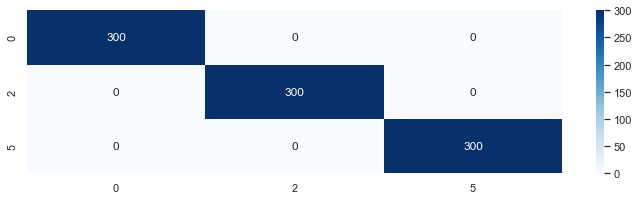

In [ ]:
import pandas as pd
import seaborn as sn

def val_model(model, dataloaders, optimizer):
    false_img_count = 0
    phase = 'val'
    confusion_matrix = torch.zeros(num_classes, num_classes)
    model.eval()
    for inputs, labels in dataloaders[phase]:
        inputs = inputs.to(device)
        labels = labels.to(device)
        optimizer.zero_grad()
        with torch.set_grad_enabled(phase == 'train'):
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            _, preds = torch.max(outputs, 1)

            #######################################################
            for i in range(inputs.size()[0]):
                if preds[i] != labels[i]:
                    input = tensor_to_np(inputs.cpu().data[i])
                    print(input)
                    input *= 255
                    input = input.astype(np.uint8)
                    
                    false_img_save(preds[i], labels[i], input, false_img_count)
                    false_img_count += 1

            #######################################################

            for t_confusion_matrix, p_confusion_matrix in zip(labels.view(-1), preds.view(-1)):
                confusion_matrix[t_confusion_matrix.long(), p_confusion_matrix.long()] += 1
    
    confusion_matrix_numpy = confusion_matrix.to('cpu').detach().numpy().copy()
    df_cmx = pd.DataFrame(confusion_matrix_numpy, index=class_names, columns=class_names)
    plt.figure(figsize = (12, 3))
    sn.set(font_scale = 1)
    sn.heatmap(df_cmx, annot=True, fmt='g', cmap='Blues')
    plt.savefig(os.path.join(out_dir,"confusion_matrix.png"))
    sn.set(font_scale = 1)

val_model(model_ft, dataloaders_dict, optimizer_ft)

In [ ]:
print(class_names)

['0', '2', '5']


In [ ]:
def save_txtfile(data, outpath):
  file = outpath
  fileobj = open(file, "w", encoding = "utf_8")
  for index , i in enumerate(data):
    if index == len(data) - 1:
      fileobj.write(f"{i}")
    else:
      fileobj.write(f"{i},")

  fileobj.close()

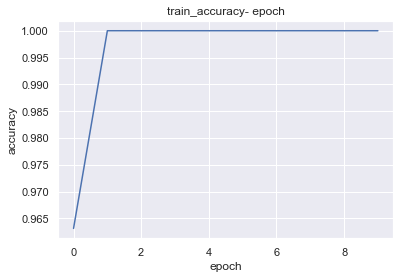

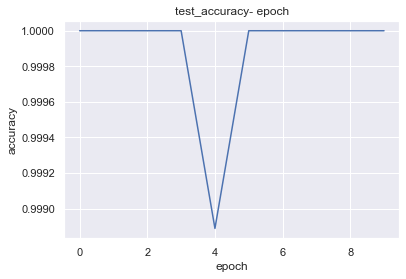

In [ ]:
train_acc_hist = []
val_acc_hist = []

for i in train_acc_hist_tensor:
  train_acc_hist.append(float(i.item()))

for i in val_acc_hist_tensor:
  val_acc_hist.append(float(i.item()))

plt.plot(train_acc_hist)
plt.title("train_accuracy- epoch")
plt.xlabel("epoch")
plt.ylabel("accuracy")
plt.grid(True)
plt.savefig(os.path.join(out_dir,"train_acc.png"))
plt.show()

plt.plot(val_acc_hist)
plt.title("test_accuracy- epoch")
plt.xlabel("epoch")
plt.ylabel("accuracy")
plt.grid(True)
plt.savefig(os.path.join(out_dir,"val_acc.png"))
plt.show()

save_txtfile(train_acc_hist, os.path.join(out_dir,"train_acc_hist.txt"))
save_txtfile(val_acc_hist, os.path.join(out_dir,"val_acc_hist.txt"))

torch.Size([3, 224, 224])
torch.Size([3, 224, 224])
torch.Size([3, 224, 224])
torch.Size([3, 224, 224])
torch.Size([3, 224, 224])
torch.Size([3, 224, 224])


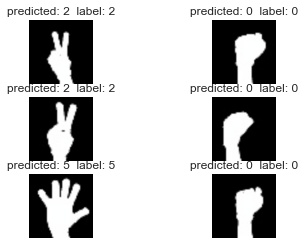

In [ ]:
def visualize_model(model, dataloaders, num_images=6):
    was_training = model.training
    model.eval()
    images_so_far = 0
    fig = plt.figure()

    with torch.no_grad():
        for i, (inputs, labels) in enumerate(dataloaders['val']):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            for j in range(inputs.size()[0]):
                images_so_far += 1
                ax = fig.add_subplot(num_images//2, 2, images_so_far)
                ax.axis('off')
                ax.set_title('predicted: {}  label: {}'
                             .format(class_names[preds[j]], class_names[labels[j]]))
                
                print(inputs.cpu().data[j].size())
                ax.imshow(tensor_to_np(inputs.cpu().data[j]))

                if images_so_far == num_images:
                    model.train(mode=was_training)
                    return
        model.train(mode=was_training)

visualize_model(model_ft, dataloaders_dict)

In [ ]:
torch.save(model_ft.state_dict(), os.path.join(out_dir,'model_weights.pth'))